## Sentiment Analysis of Tweets

In [12]:
import tweepy
from tweepy import Cursor
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.style.use(['dark_background'])
%matplotlib inline

In [4]:
# Authentication requirements
app = pd.read_csv('../keys.csv')

consumerKey = app['Key'][0]
consumerSecret = app['SecretKey'][0]
accessToken = app['Token'][0]
accessTokenSecret = app['SecetToken'][0] # Misspelled secret on accident

In [5]:
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

authenticate.set_access_token(accessToken, accessTokenSecret)

api = tweepy.API(auth_handler=authenticate, wait_on_rate_limit=True)

### Scraping Twitter

In [ ]:
text_query = 'great reset'
max_tweets = 2000
 
# Creation of query method using parameters
tweets = tweepy.Cursor(api.search, q=text_query).items(max_tweets)
 
tweet_list = [[tweet.text, tweet.created_at, tweet.id_str, tweet.user.name, 
               tweet.user.screen_name, tweet.user.location, tweet.user.description, 
               tweet.user.verified, tweet.user.followers_count, tweet.user.friends_count, 
               tweet.user.favourites_count, tweet.user.statuses_count, 
               tweet.user.listed_count, tweet.user.created_at] for tweet in tweets]
 
tweet_df = pd.DataFrame(tweet_list)

tweet_df.shape

In [ ]:
cols = ['text', 'tweet_created', 'tweet_id', 'username', 'screen_name', 'location', 'user_descr', 'verified', 'follower_num', 'friends_num', 'favs_num', 'status_num', 'listed_num', 'user_created']

tweets_df.columns = cols

# tweet_df.to_csv('great-reset-1000.csv', index=False, header=tweet_df.columns.values)
tweet_df.head()

- `tweet.text`: text content of tweet
- `tweet.created_at`: date tweet was created_at
- `tweet.id_str`: id of tweet
- `tweet.user.screen_name`: username of tweets author
- `tweet.coordinates`: geographic location
- `tweet.place`; where user signed up when created 
- `tweet.retweet_count`: count of retweets
- `tweet.favorite_count`: count of favorites
- `tweet.source`: source
- `tweet.in_reply_to_user_id_str`: if a tweet is a reply 
- `tweet.is_quote_status`: if a tweet is a quote tweet 

### Import Saved CSV

In [7]:
df = pd.read_csv('../great-reset-2000.csv')
df.head()

text        tweet_created  \
0  RT @FriendsOScience: @PierrePoilievre https://...  2020-11-18 05:23:57   
1  RT @janekin24: Why is every western leader fal...  2020-11-18 05:23:55   
2  RT @BreitbartNews: NOLTE: "Could it be we are ...  2020-11-18 05:23:53   
3  RT @adamseconomics: 🚨 BREAKING 🚨\n\nA Federal ...  2020-11-18 05:23:51   
4  RT @SkyNewsAust: Nationals Senator @mattjcan s...  2020-11-18 05:23:48   

              tweet_id      username    screen_name             location  \
0  1328931930449072131  Buck Murdock   TedStriker33                  NaN   
1  1328931923415199747      Carrie B     KayLynne63  Nottingham, England   
2  1328931913873190913    Jojie Ivai  Ariahsmummy19         Port Moresby   
3  1328931905090236420        twawki        twawki2       global citizen   
4  1328931895187550213   Cephas Zone     CephasZone                  NaN   

                                          user_descr  verified  follower_num  \
0                                                NaN     False           911   
1                                                 🐿️     False           527   
2  New On social Media.. Jesus is the Most Powerf...     False            59   
3  time to fly\nhold fast to our dreams\novercome...     False         11063   
4  Was a V2 Catholic in my youth; now I support T...     False          2884   

   friends_num  favs_num  status_num  listed_num         user_created  
0         1280     65765       55475           5  2014-07-30 15:14:53  
1         1233     10107        2770           0  2014-04-22 21:01:12  
2          118       682         372           0  2020-08-03 00:14:57  
3        11859     23209       69964           1  2019-09-13 07:16:22  
4         2490      4461       14370          20  2015-06-15 04:11:58

In [9]:
def cleaned(df, col):
    df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')) # Remove emojis
    df[col] = df[col].replace(r'@[\w]+', '', regex=True).replace(r'#', '', regex=True) # Remove mentions
    df[col] = df[col].replace(r'RT[\s]+', '', regex=True) # Remove retweets
    df[col] = df[col].replace(r'https?:\/\/(www\.)?\S', '', regex=True) # Remove https links
    df[col] = df[col].replace(r'.co\/(\w)+', '', regex=True).replace(r':', '', regex=True) # Remove co links
    df[col] = df[col].replace(r'https…', '', regex=True) # edge case
    df[col] = df[col].replace(r'\n', ' ', regex=True) # Remove newline

    df = df.applymap(lambda x: x.strip() if type(x) == str else x).astype(str)
    # Had to use this for the 'practice.csv', so left it in just in case
    df_cleaned = df[~df['text'].str.contains('nan')]  
    df = df_cleaned.copy()

    return df[col]

df['text'] = cleaned(df, 'text')

df.head()

text        tweet_created  \
0                                          Thanks to  2020-11-18 05:23:57   
1  Why is every western leader falling for the gr...  2020-11-18 05:23:55   
2  NOLTE "Could it be we are being softened up fo...  2020-11-18 05:23:53   
3  BREAKING   A Federal Coalition Parliamentarian...  2020-11-18 05:23:51   
4  Nationals Senator  says the World Economic For...  2020-11-18 05:23:48   

              tweet_id      username    screen_name             location  \
0  1328931930449072131  Buck Murdock   TedStriker33                  NaN   
1  1328931923415199747      Carrie B     KayLynne63  Nottingham, England   
2  1328931913873190913    Jojie Ivai  Ariahsmummy19         Port Moresby   
3  1328931905090236420        twawki        twawki2       global citizen   
4  1328931895187550213   Cephas Zone     CephasZone                  NaN   

                                          user_descr  verified  follower_num  \
0                                                NaN     False           911   
1                                                 🐿️     False           527   
2  New On social Media.. Jesus is the Most Powerf...     False            59   
3  time to fly\nhold fast to our dreams\novercome...     False         11063   
4  Was a V2 Catholic in my youth; now I support T...     False          2884   

   friends_num  favs_num  status_num  listed_num         user_created  
0         1280     65765       55475           5  2014-07-30 15:14:53  
1         1233     10107        2770           0  2014-04-22 21:01:12  
2          118       682         372           0  2020-08-03 00:14:57  
3        11859     23209       69964           1  2019-09-13 07:16:22  
4         2490      4461       14370          20  2015-06-15 04:11:58

## TextBlob

In [10]:
def text_blob(df, col):
    testimonial = [TextBlob(str(item)) for item in df[col]]
    blobs = [item.sentiment for item in testimonial]
    blob_df = pd.DataFrame(blobs)
    df_combined = pd.concat([df, blob_df], axis=1)
    return df_combined

df = text_blob(df, 'text')
df.head()

text        tweet_created  \
0                                          Thanks to  2020-11-18 05:23:57   
1  Why is every western leader falling for the gr...  2020-11-18 05:23:55   
2  NOLTE "Could it be we are being softened up fo...  2020-11-18 05:23:53   
3  BREAKING   A Federal Coalition Parliamentarian...  2020-11-18 05:23:51   
4  Nationals Senator  says the World Economic For...  2020-11-18 05:23:48   

              tweet_id      username    screen_name             location  \
0  1328931930449072131  Buck Murdock   TedStriker33                  NaN   
1  1328931923415199747      Carrie B     KayLynne63  Nottingham, England   
2  1328931913873190913    Jojie Ivai  Ariahsmummy19         Port Moresby   
3  1328931905090236420        twawki        twawki2       global citizen   
4  1328931895187550213   Cephas Zone     CephasZone                  NaN   

                                          user_descr  verified  follower_num  \
0                                                NaN     False           911   
1                                                 🐿️     False           527   
2  New On social Media.. Jesus is the Most Powerf...     False            59   
3  time to fly\nhold fast to our dreams\novercome...     False         11063   
4  Was a V2 Catholic in my youth; now I support T...     False          2884   

   friends_num  favs_num  status_num  listed_num         user_created  \
0         1280     65765       55475           5  2014-07-30 15:14:53   
1         1233     10107        2770           0  2014-04-22 21:01:12   
2          118       682         372           0  2020-08-03 00:14:57   
3        11859     23209       69964           1  2019-09-13 07:16:22   
4         2490      4461       14370          20  2015-06-15 04:11:58   

   polarity  subjectivity  
0  0.200000      0.200000  
1  0.383333      0.433333  
2  0.000000      0.000000  
3  0.000000      0.000000  
4  0.133333      0.616667

## WordCloud

(-0.5, 599.5, 399.5, -0.5)

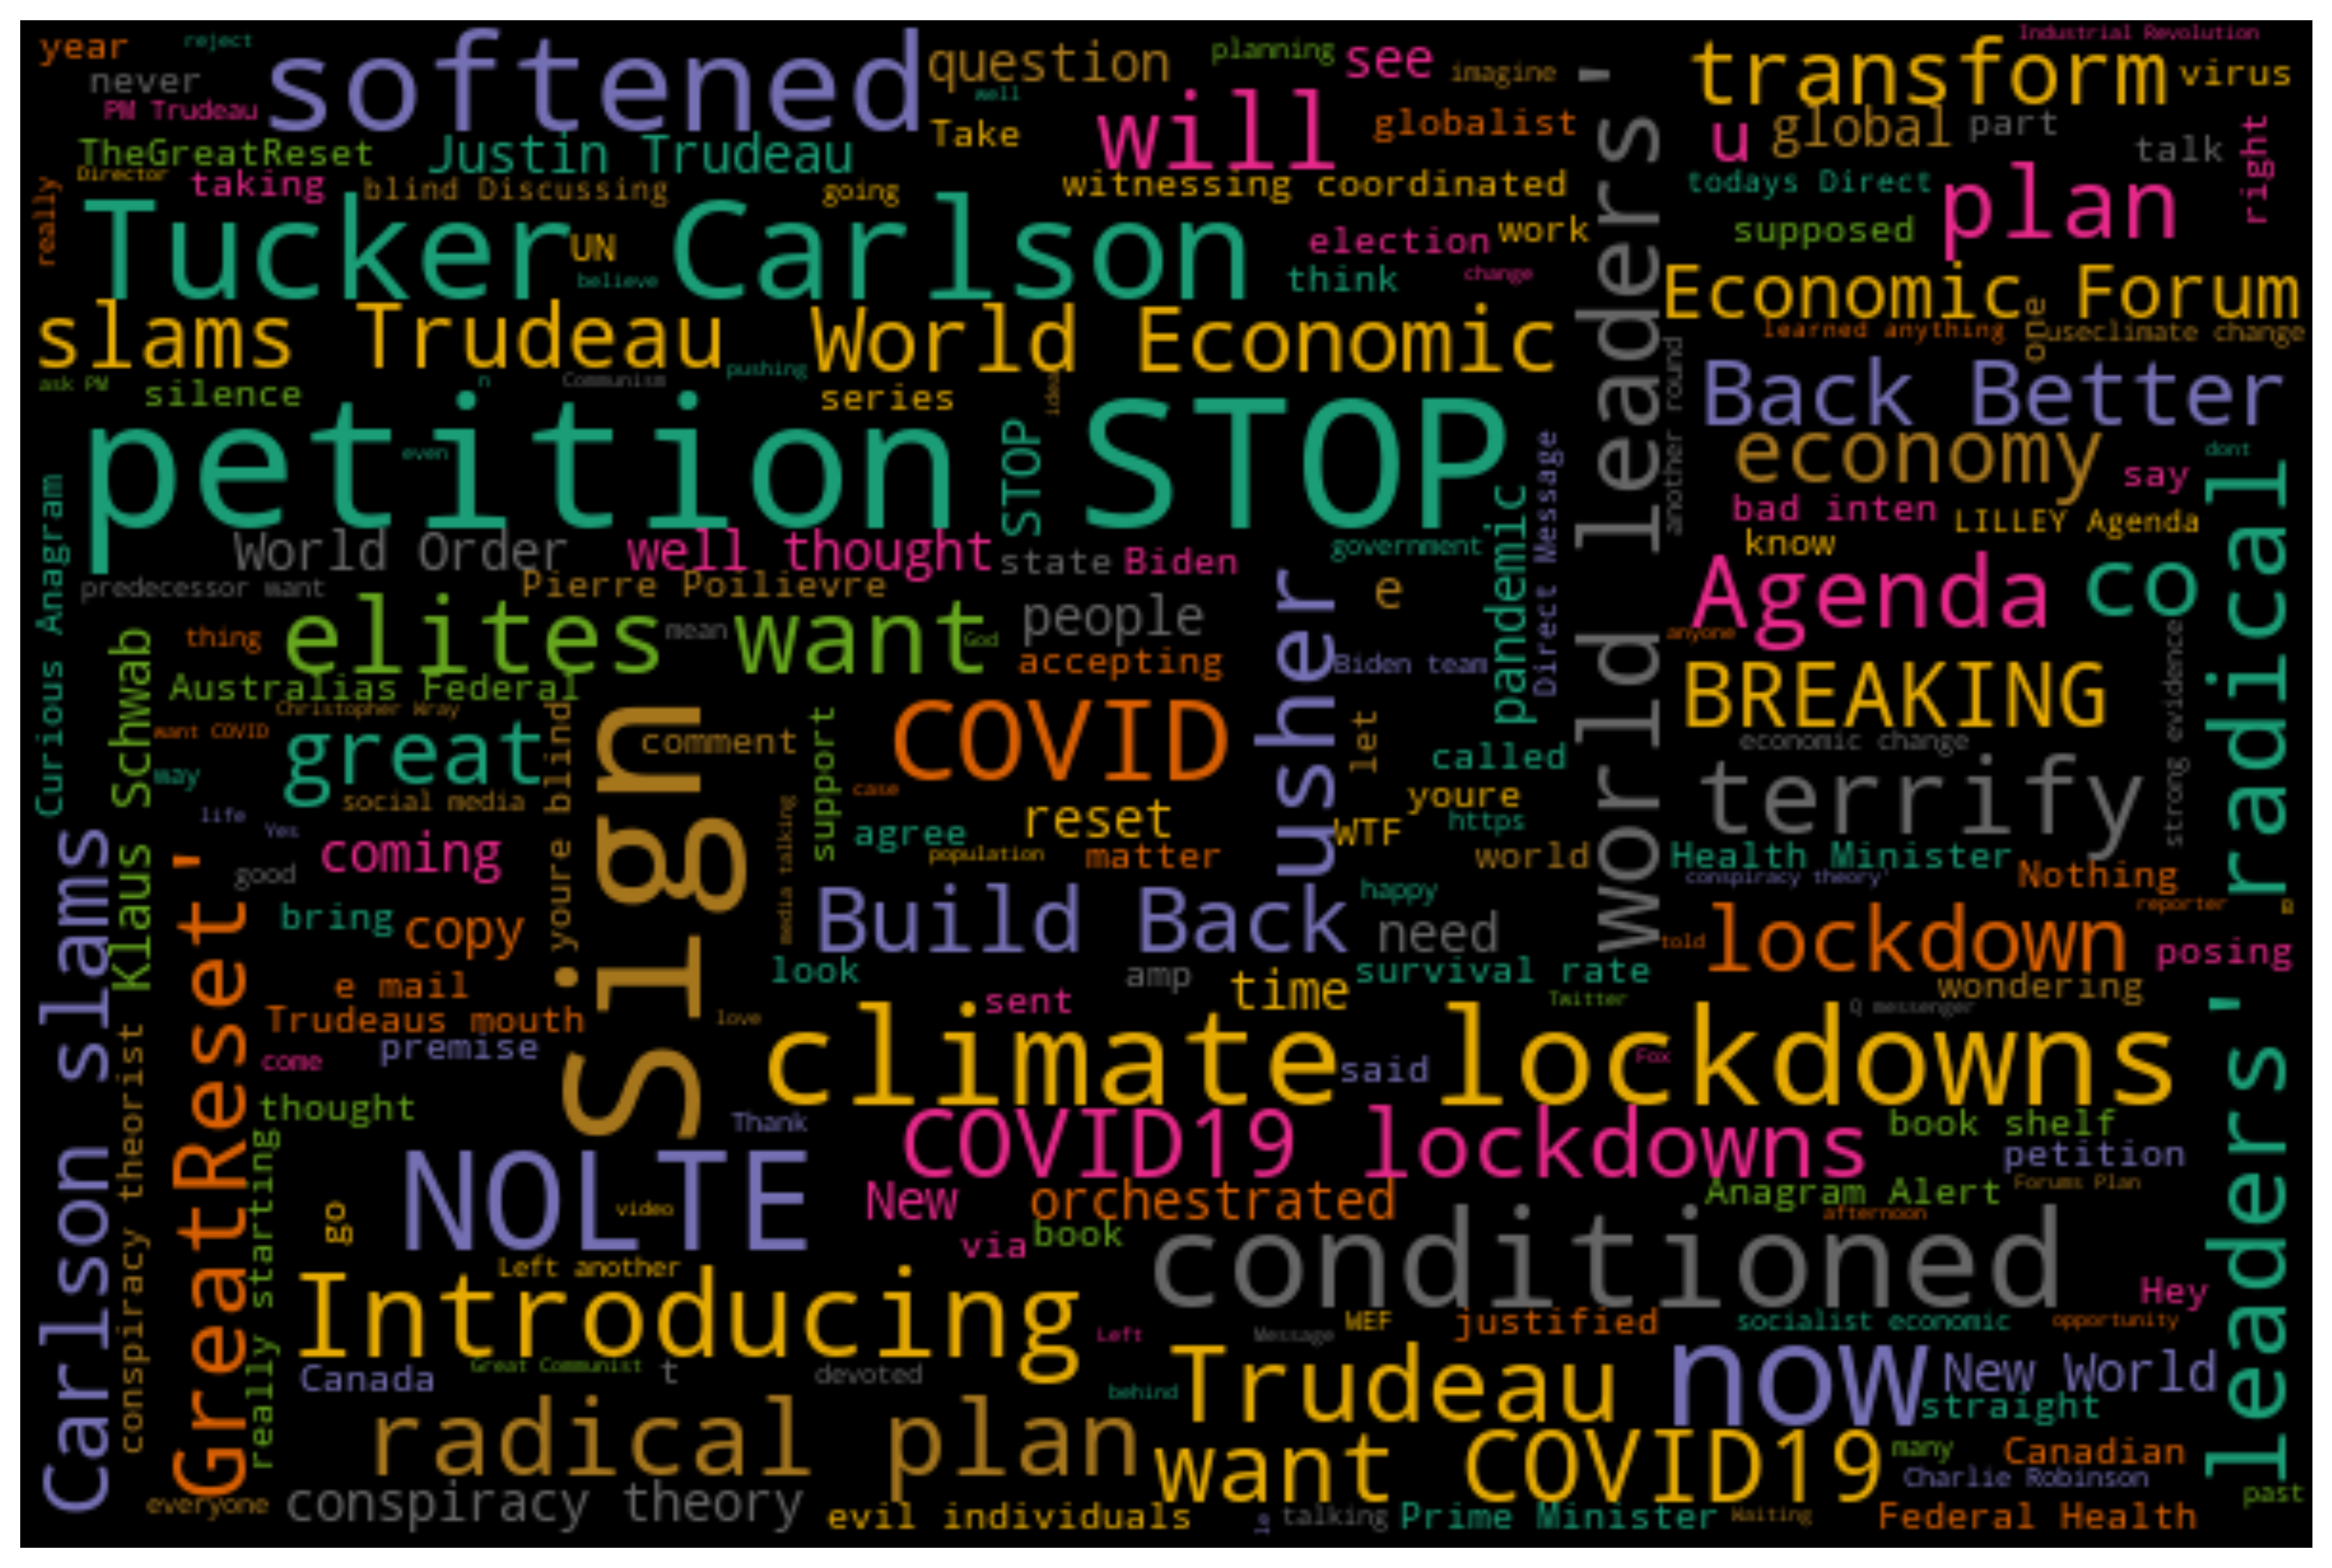

In [21]:
# String of all tweets joined together
all_words = ' '.join([str(tweet) for tweet in df['text']])
# Remove 'great reset' (the search query on twitter)
words = re.sub(r'great reset', '', all_words, flags=re.IGNORECASE)

word_cloud = WordCloud(height=400, width=600, max_font_size=50,
                      colormap='Dark2').generate(words)

plt.figure(figsize=(20, 10), dpi=300)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off');

### Classifying Polarity

In [23]:
def classify(polarity):
    if polarity < 0:
        return 'neg'
    elif polarity == 0:
        return 'neu'
    else:
        return 'pos'

df['classification'] = df['polarity'].apply(classify)
df.head()

text        tweet_created  \
0                                          Thanks to  2020-11-18 05:23:57   
1  Why is every western leader falling for the gr...  2020-11-18 05:23:55   
2  NOLTE "Could it be we are being softened up fo...  2020-11-18 05:23:53   
3  BREAKING   A Federal Coalition Parliamentarian...  2020-11-18 05:23:51   
4  Nationals Senator  says the World Economic For...  2020-11-18 05:23:48   

              tweet_id      username    screen_name             location  \
0  1328931930449072131  Buck Murdock   TedStriker33                  NaN   
1  1328931923415199747      Carrie B     KayLynne63  Nottingham, England   
2  1328931913873190913    Jojie Ivai  Ariahsmummy19         Port Moresby   
3  1328931905090236420        twawki        twawki2       global citizen   
4  1328931895187550213   Cephas Zone     CephasZone                  NaN   

                                          user_descr  verified  follower_num  \
0                                                NaN     False           911   
1                                                 🐿️     False           527   
2  New On social Media.. Jesus is the Most Powerf...     False            59   
3  time to fly\nhold fast to our dreams\novercome...     False         11063   
4  Was a V2 Catholic in my youth; now I support T...     False          2884   

   friends_num  favs_num  status_num  listed_num         user_created  \
0         1280     65765       55475           5  2014-07-30 15:14:53   
1         1233     10107        2770           0  2014-04-22 21:01:12   
2          118       682         372           0  2020-08-03 00:14:57   
3        11859     23209       69964           1  2019-09-13 07:16:22   
4         2490      4461       14370          20  2015-06-15 04:11:58   

   polarity  subjectivity classification  
0  0.200000      0.200000            pos  
1  0.383333      0.433333            pos  
2  0.000000      0.000000            neu  
3  0.000000      0.000000            neu  
4  0.133333      0.616667            pos

### Exploratory Data Analysis

In [25]:
df['classification'].value_counts()

pos    1524
neu     386
neg      90
Name: classification, dtype: int64

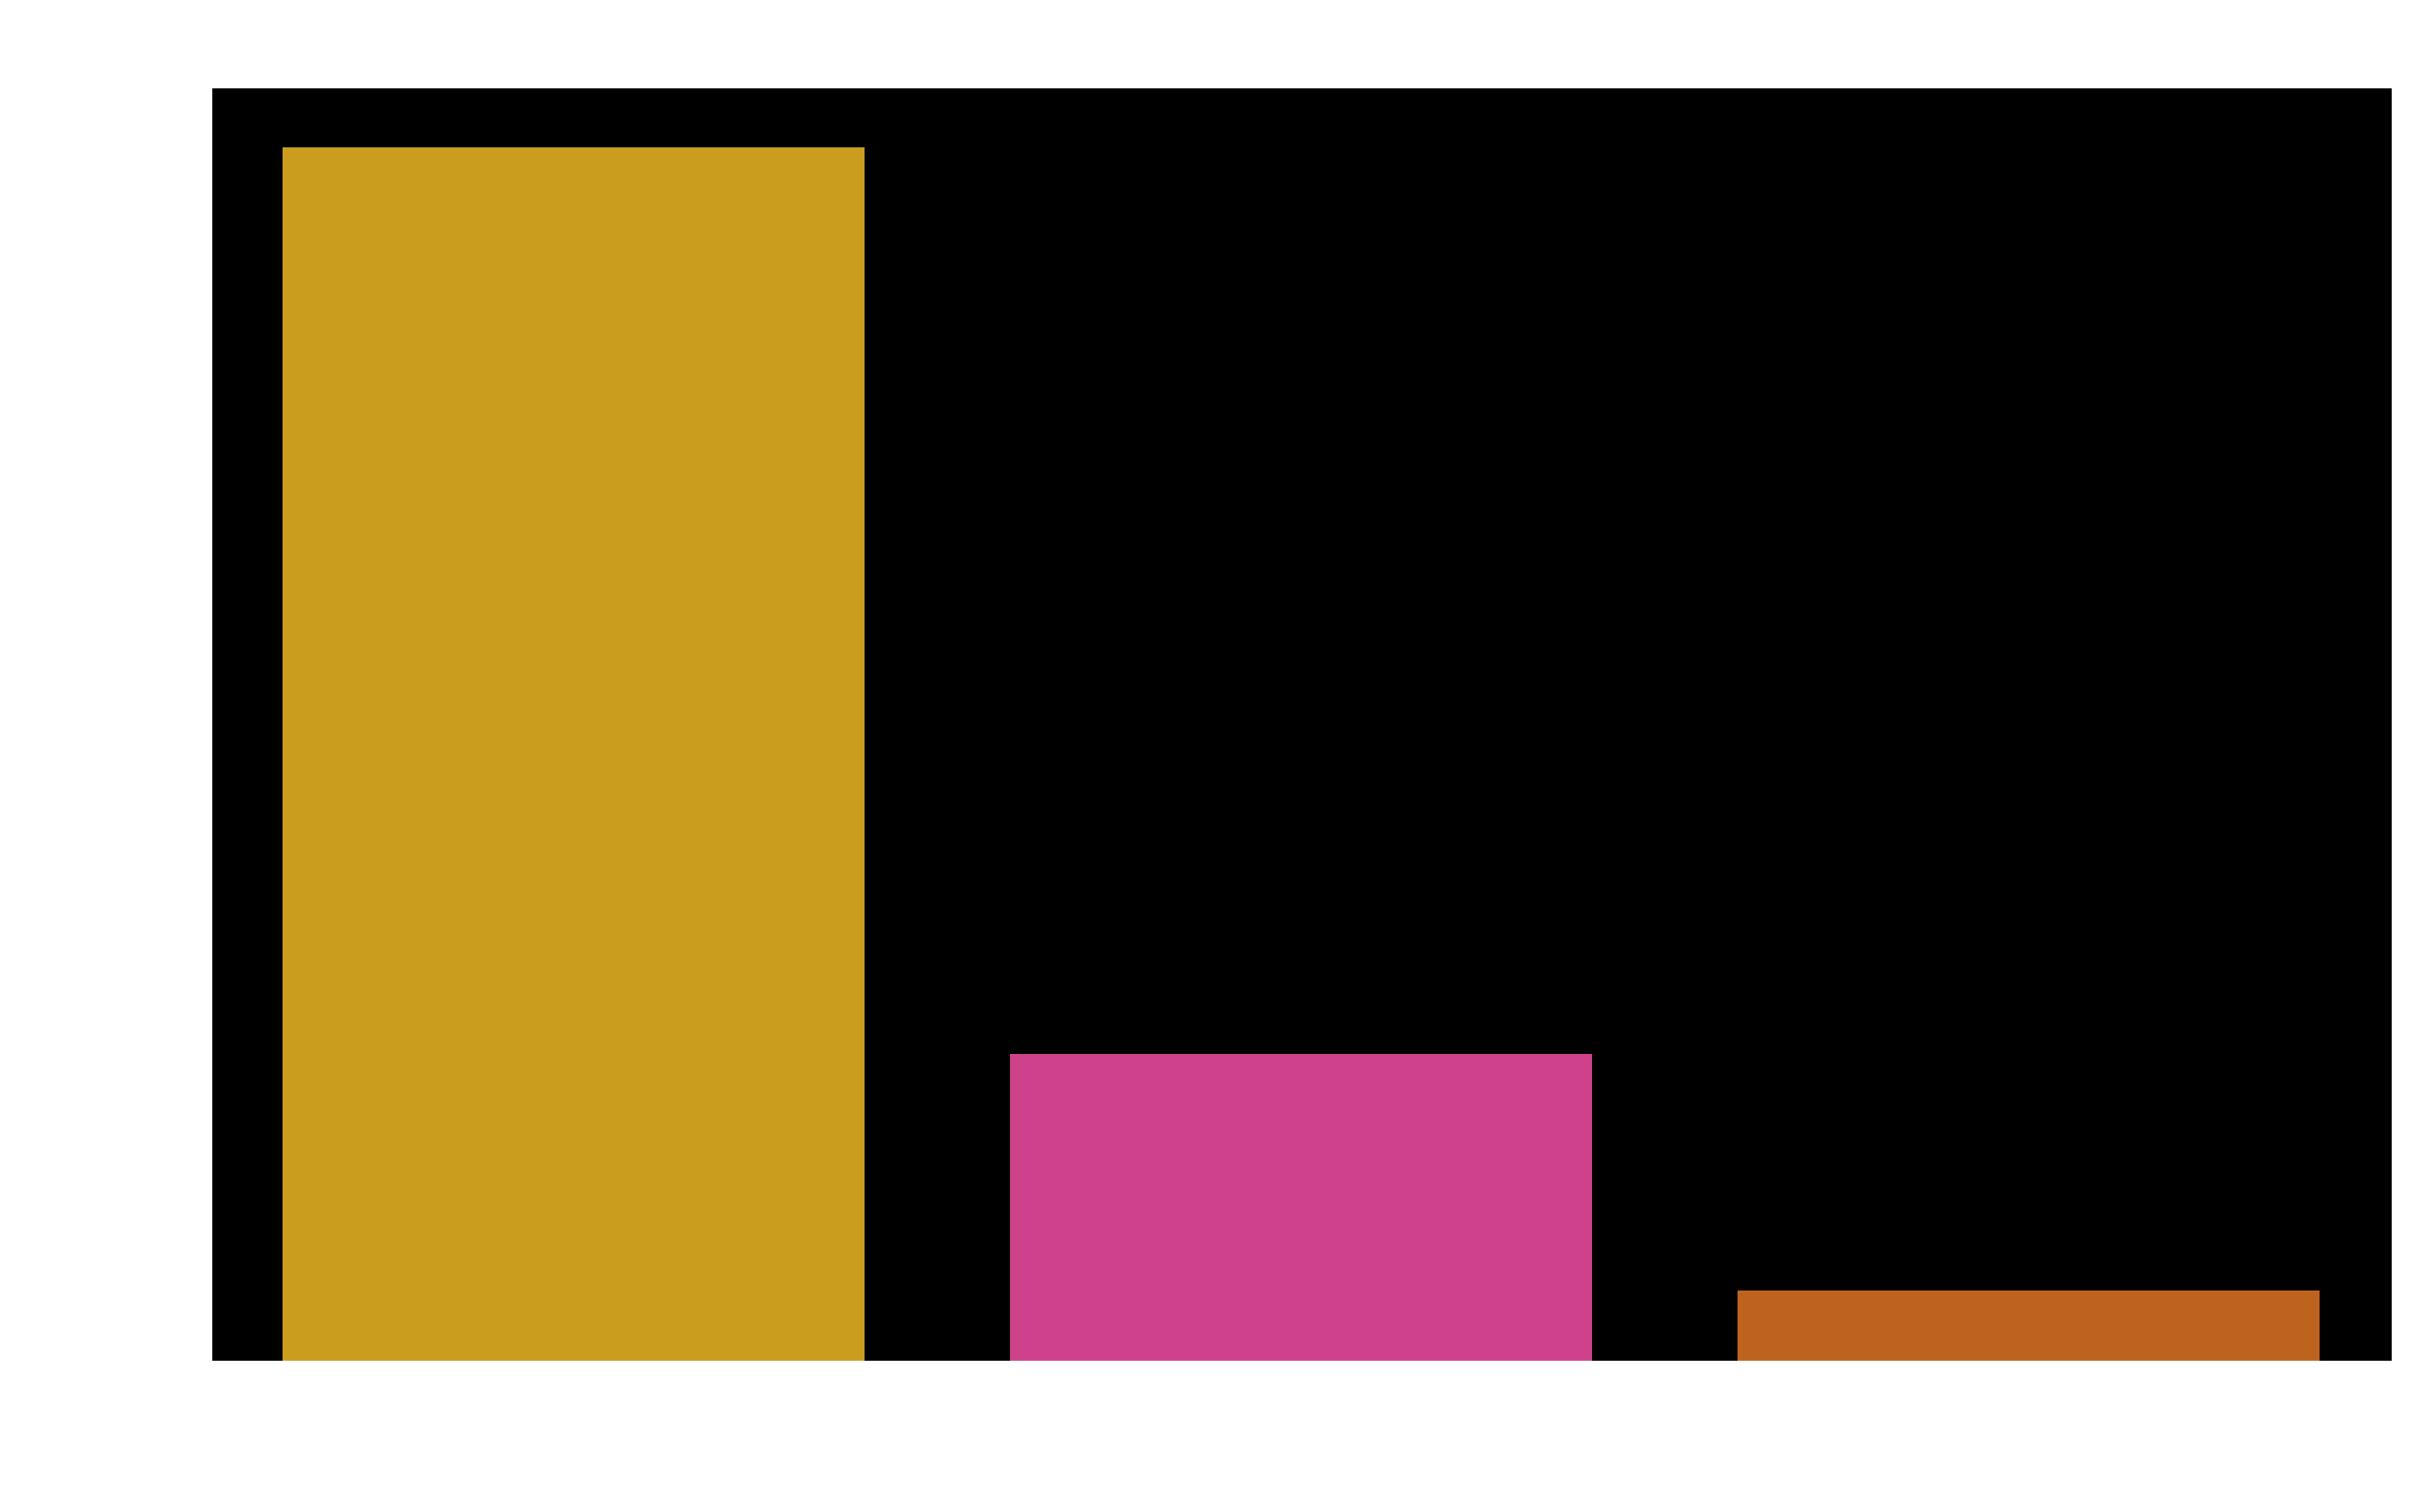

In [29]:
plt.figure(figsize=(10, 6), dpi=300)
sns.countplot(x='classification', data=df, palette='Dark2_r').set_title('Tweet Sentiment Classification Value Counts');

### Negative Tweet Previews

In [31]:
df.loc[df['polarity'] < 0, ['text', 'polarity', 'classification']].drop_duplicates(keep='first').sort_values(by='polarity')[:10]

text  polarity  \
1269  This is a well thought out plan we're witnessi... -0.850000   
210   This is a well thought out plan we're witnessi... -0.850000   
77    Stop being sensible. Now is a time for panic. ... -0.800000   
127   A disturbing movement to reform capitalism is ... -0.500000   
1389  Notice how the demonic evil psychopaths of the... -0.500000   
755   Feelings are irrelevant and dont dictate anyth... -0.500000   
964   If you want to do something about climate chan... -0.450000   
79                  No great reset for globalist scums. -0.400000   
296   "A handful of countries will dominate", shows ... -0.400000   
537   I am sick of the collective advertising messag... -0.357143   

     classification  
1269            neg  
210             neg  
77              neg  
127             neg  
1389            neg  
755             neg  
964             neg  
79              neg  
296             neg  
537             neg

### Positive Tweet Previews

In [32]:
df.loc[df['polarity'] > 0, ['text', 'polarity', 'classification']].drop_duplicates(keep='first').sort_values(by='polarity', ascending=False)[:10]

text  polarity  \
363   Se ferait-il que ns soyons conditionns pr les ...       1.0   
157   A message to Justin Trudeau  We reject your Gr...       1.0   
602   Screw the Great Reset!  Trump won!  Trump is b...       1.0   
1570  Thank GOD!  is calling out Justin Trudeau and ...       1.0   
1770  You Witch we see your plan for The Great Reset...       1.0   
1776  You are witnessing the Great Reset.........enj...       1.0   
1689  I watched it Laura Talking about The Great Res...       1.0   
585                       It's called The Great Reset !       1.0   
623   Se ferait-il que ns soyons conditionns pr les ...       1.0   
1246       I read the article. Dr. Mercola is great! He       1.0   

     classification  
363             pos  
157             pos  
602             pos  
1570            pos  
1770            pos  
1776            pos  
1689            pos  
585             pos  
623             pos  
1246            pos

### Polarity vs Subjectivity

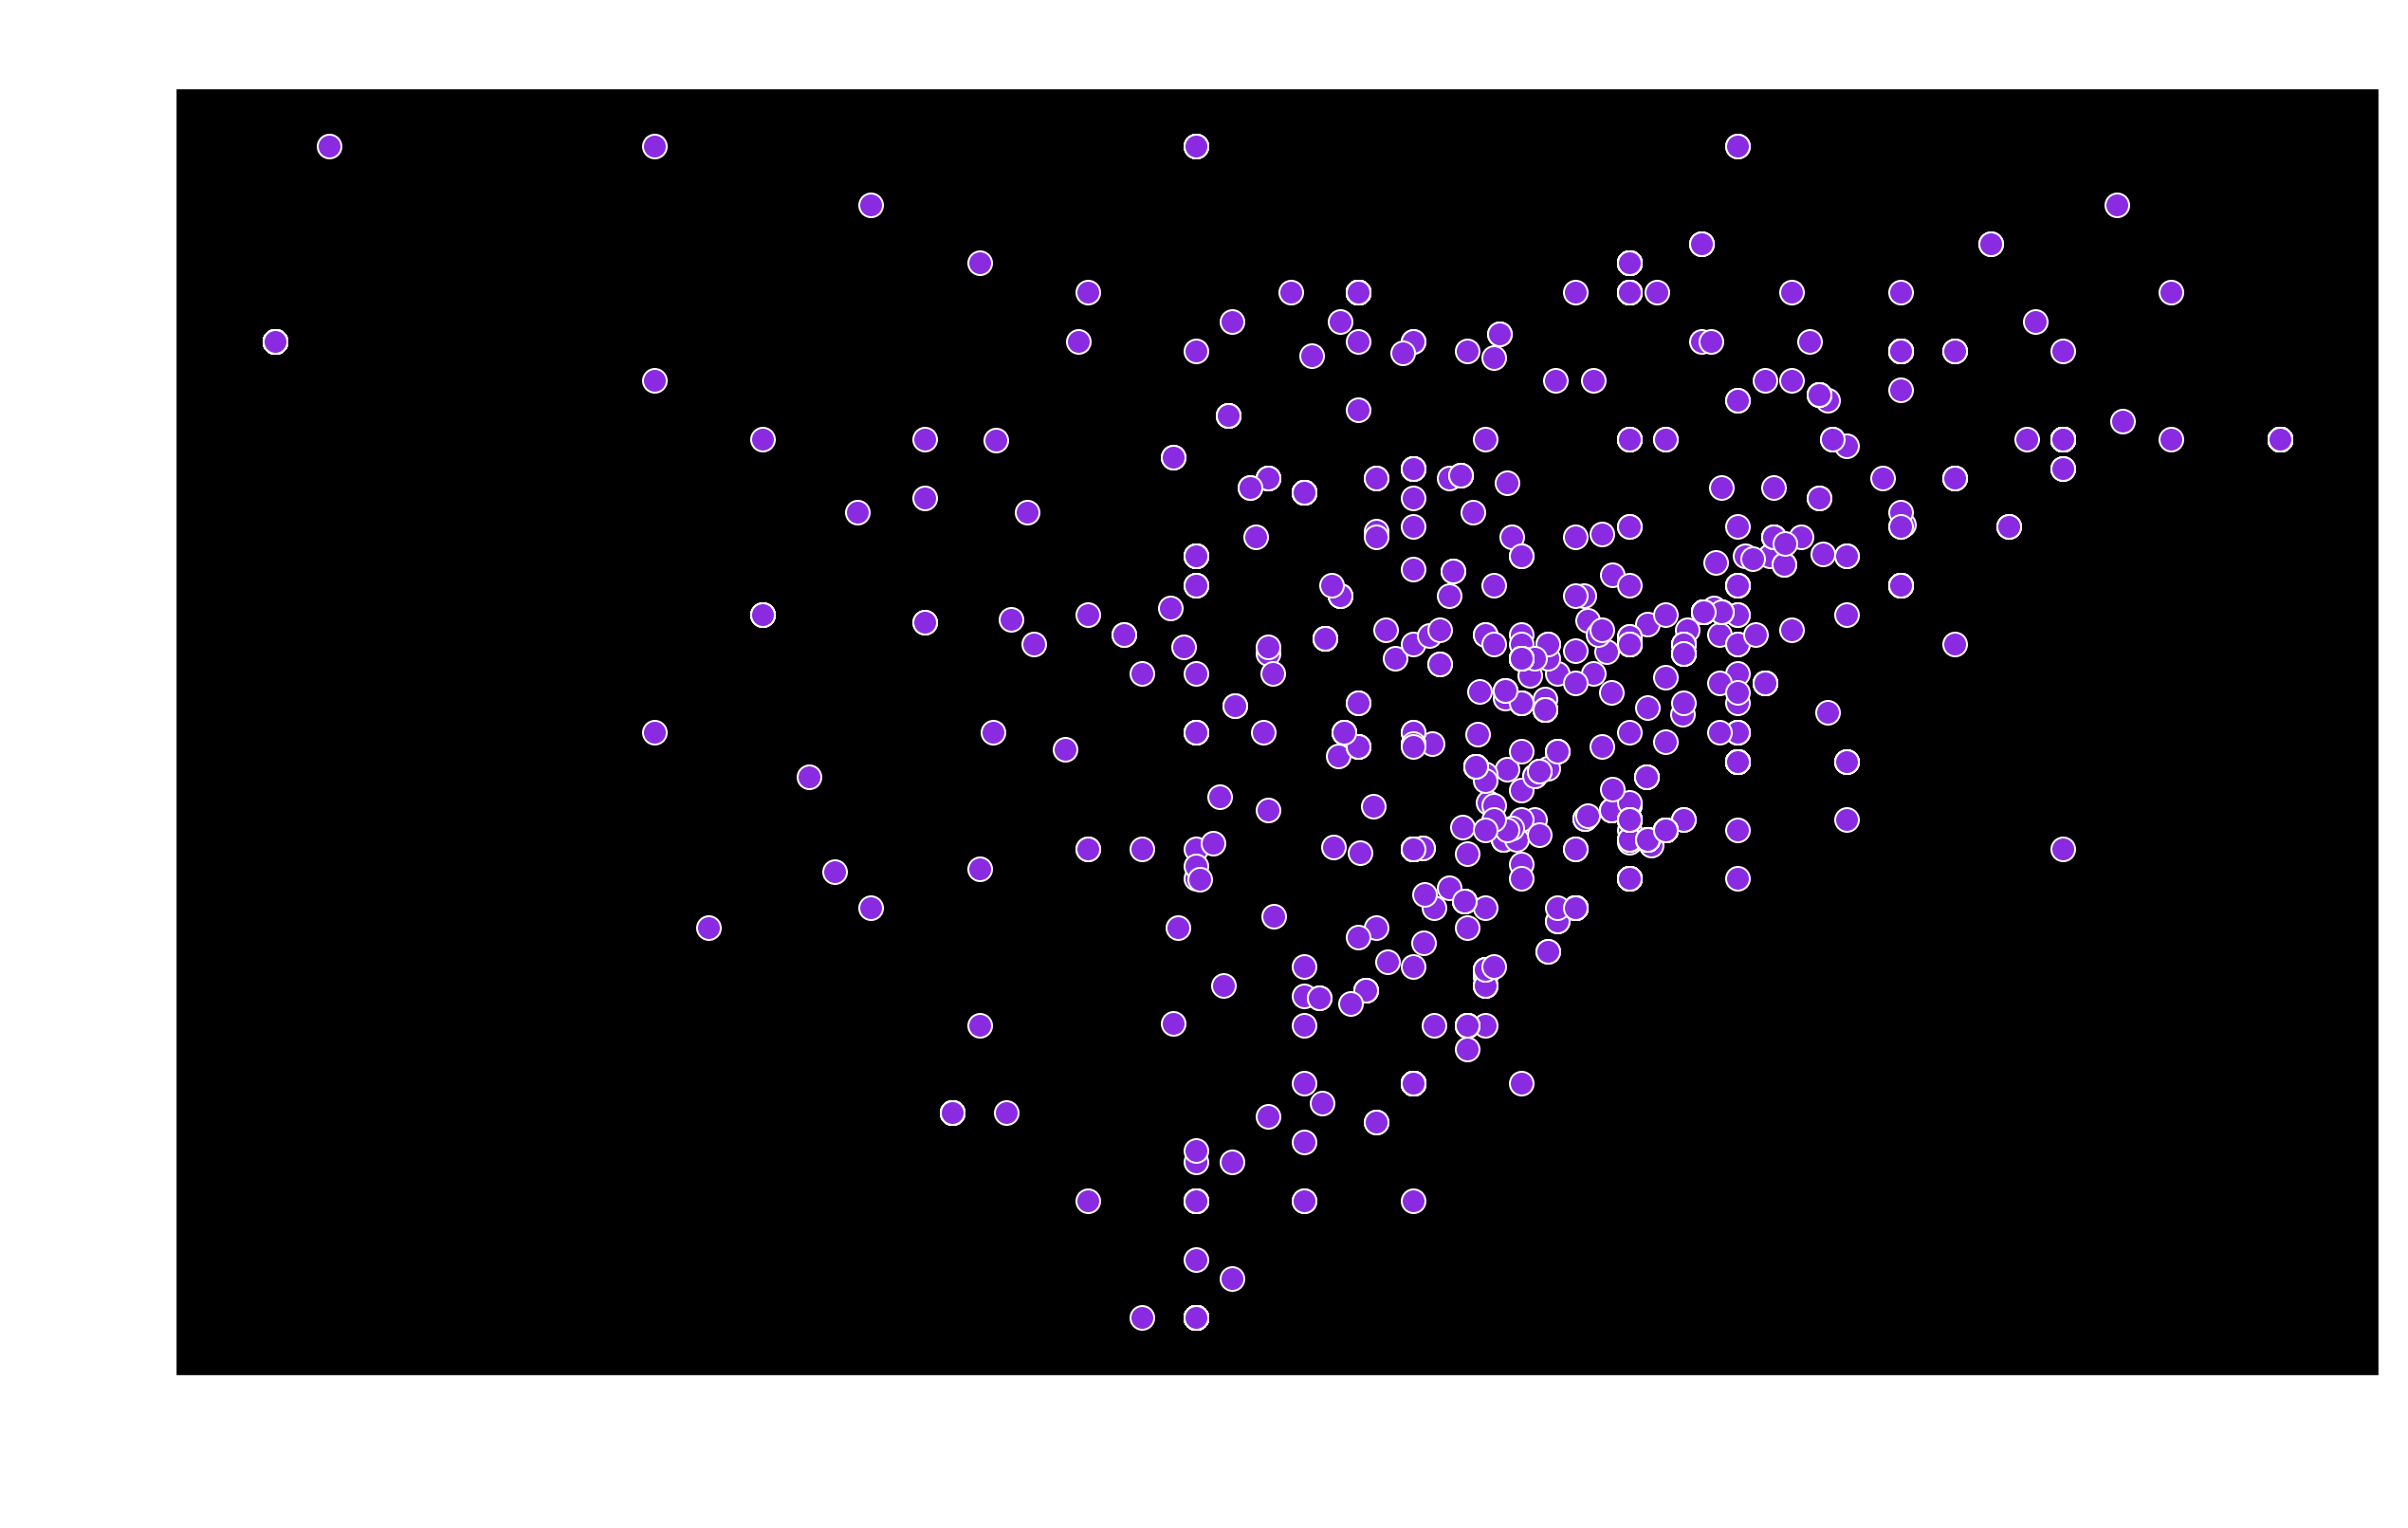

In [35]:
plt.figure(figsize=(10, 6), dpi=300)
sns.scatterplot(x=df['polarity'], y=df['subjectivity'], color='BlueViolet').set_title('Polarity vs Subjectivity of Tweets');

### Distribution of Polarity

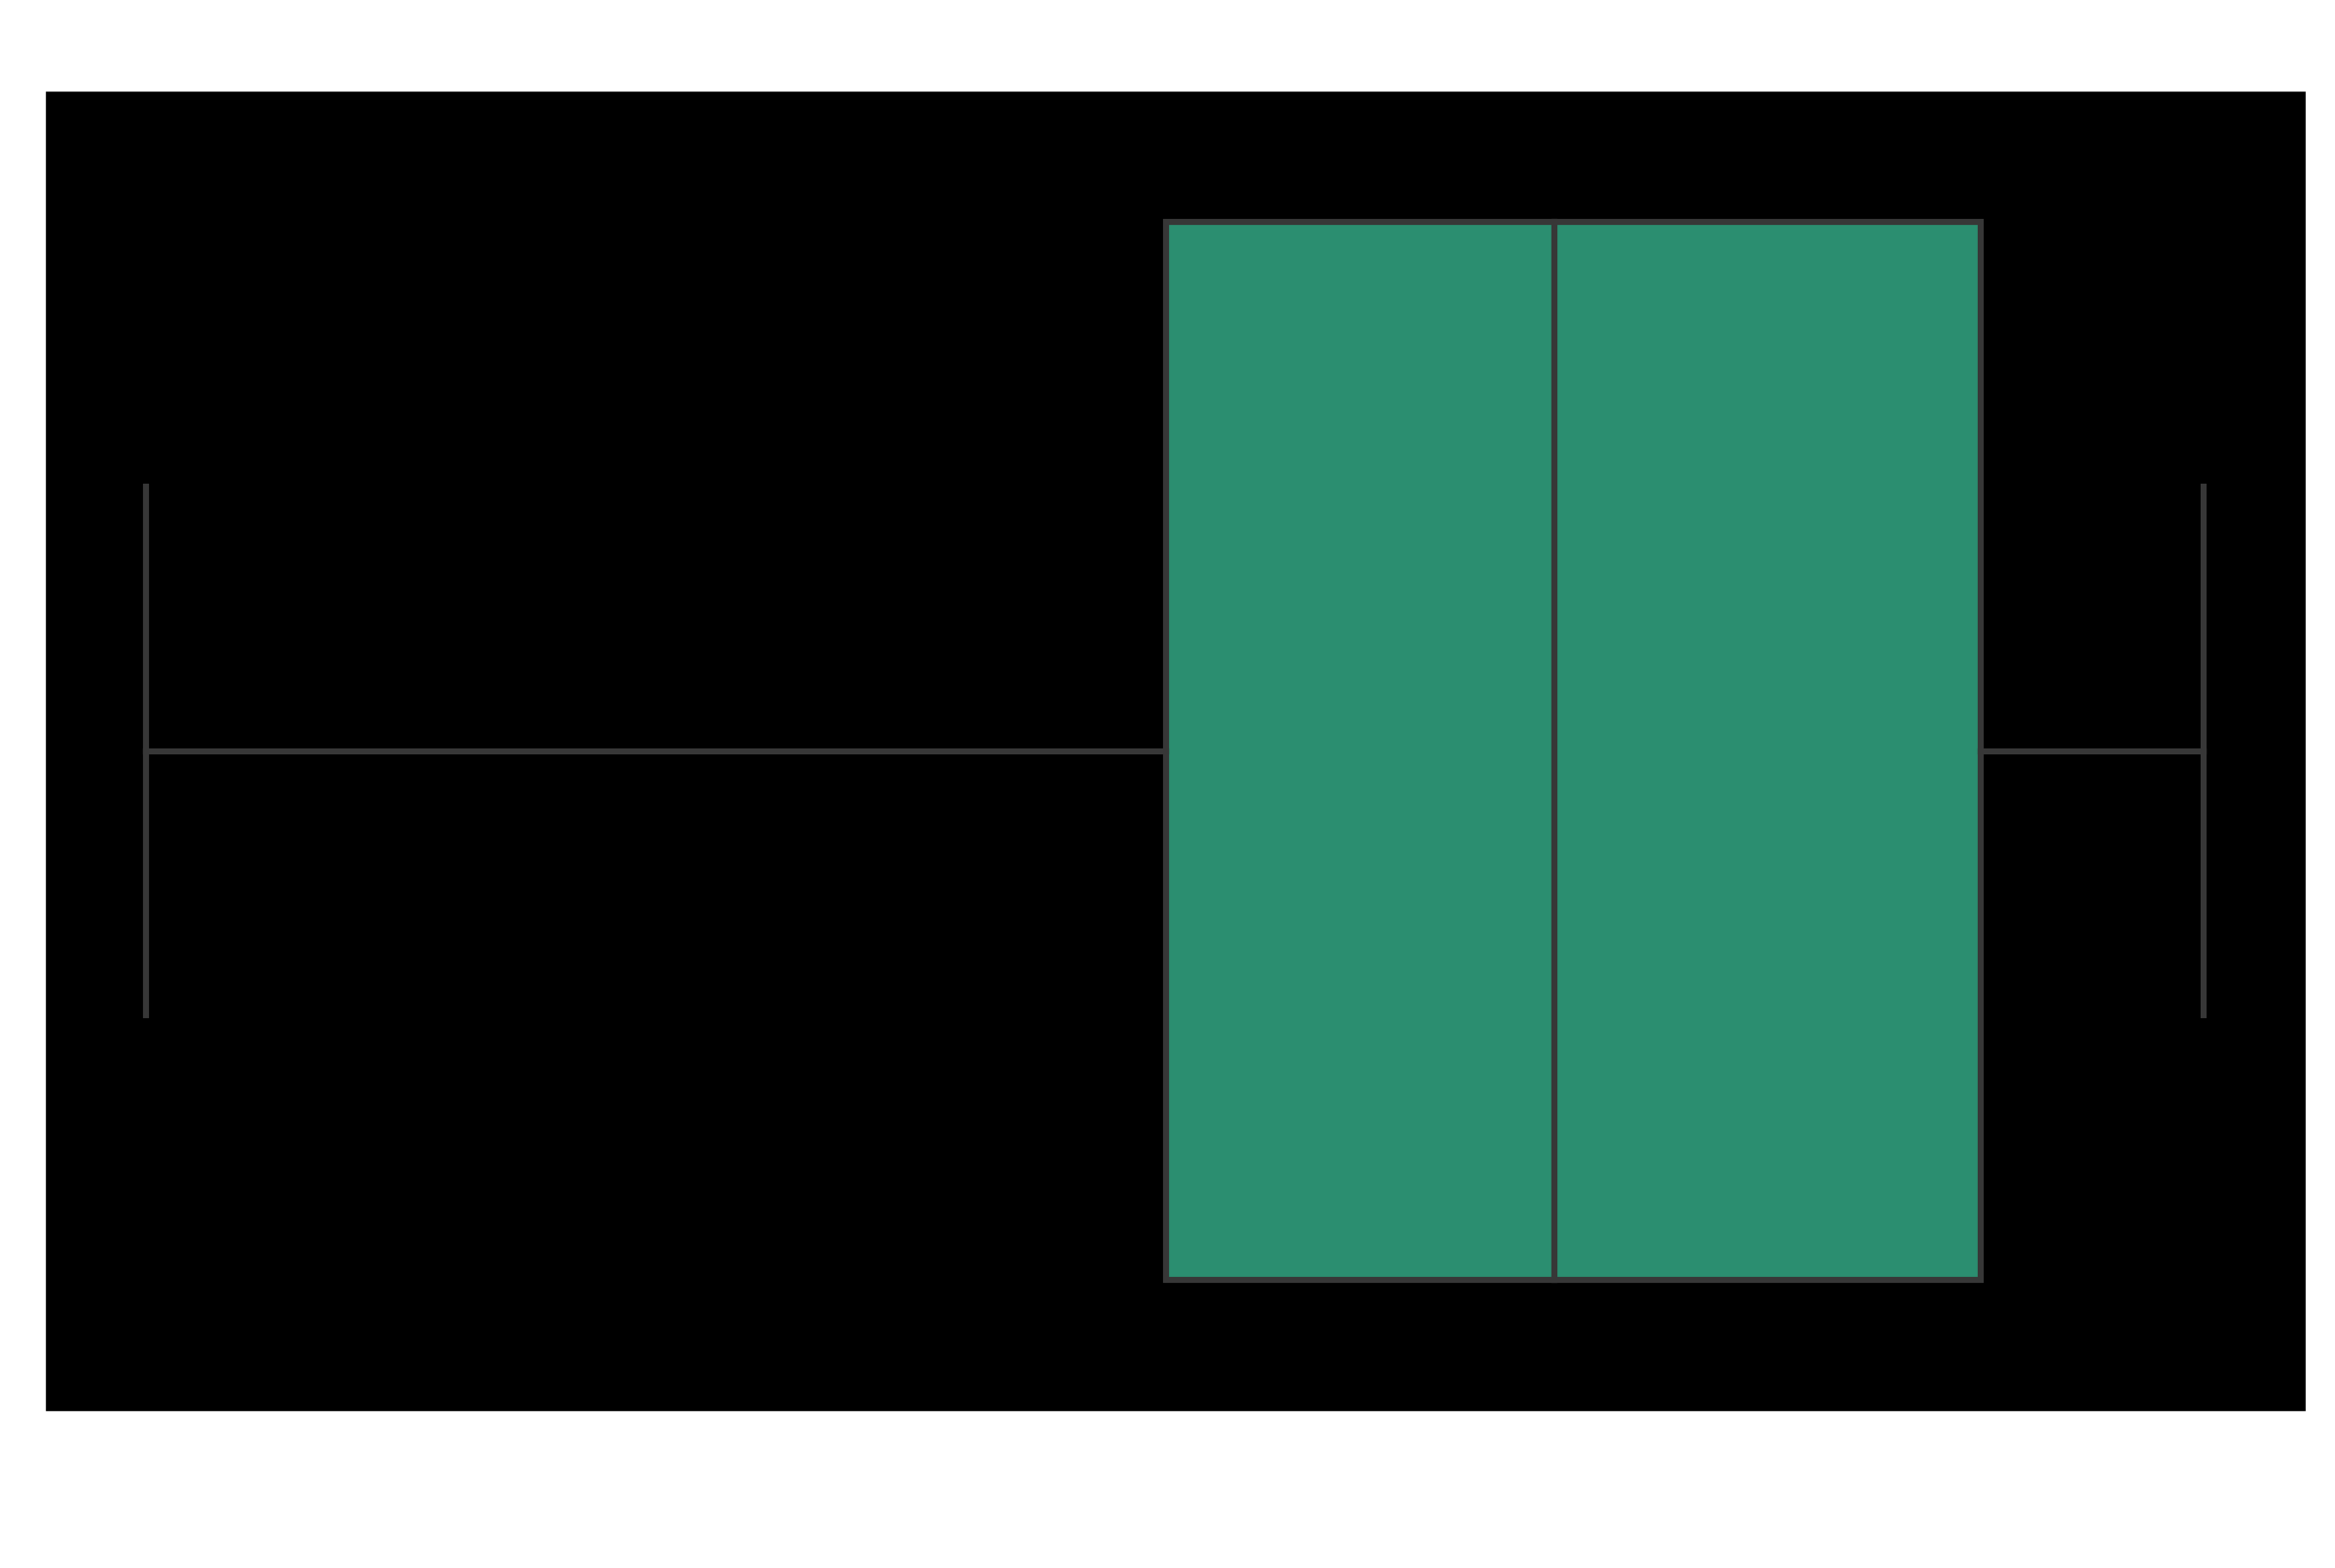

In [36]:
plt.figure(figsize=(10, 6), dpi=300)
sns.boxplot(x='polarity', data=df, palette='Dark2').set_title('Polarity Distribution');

### Verified Twitter Positive vs Negative

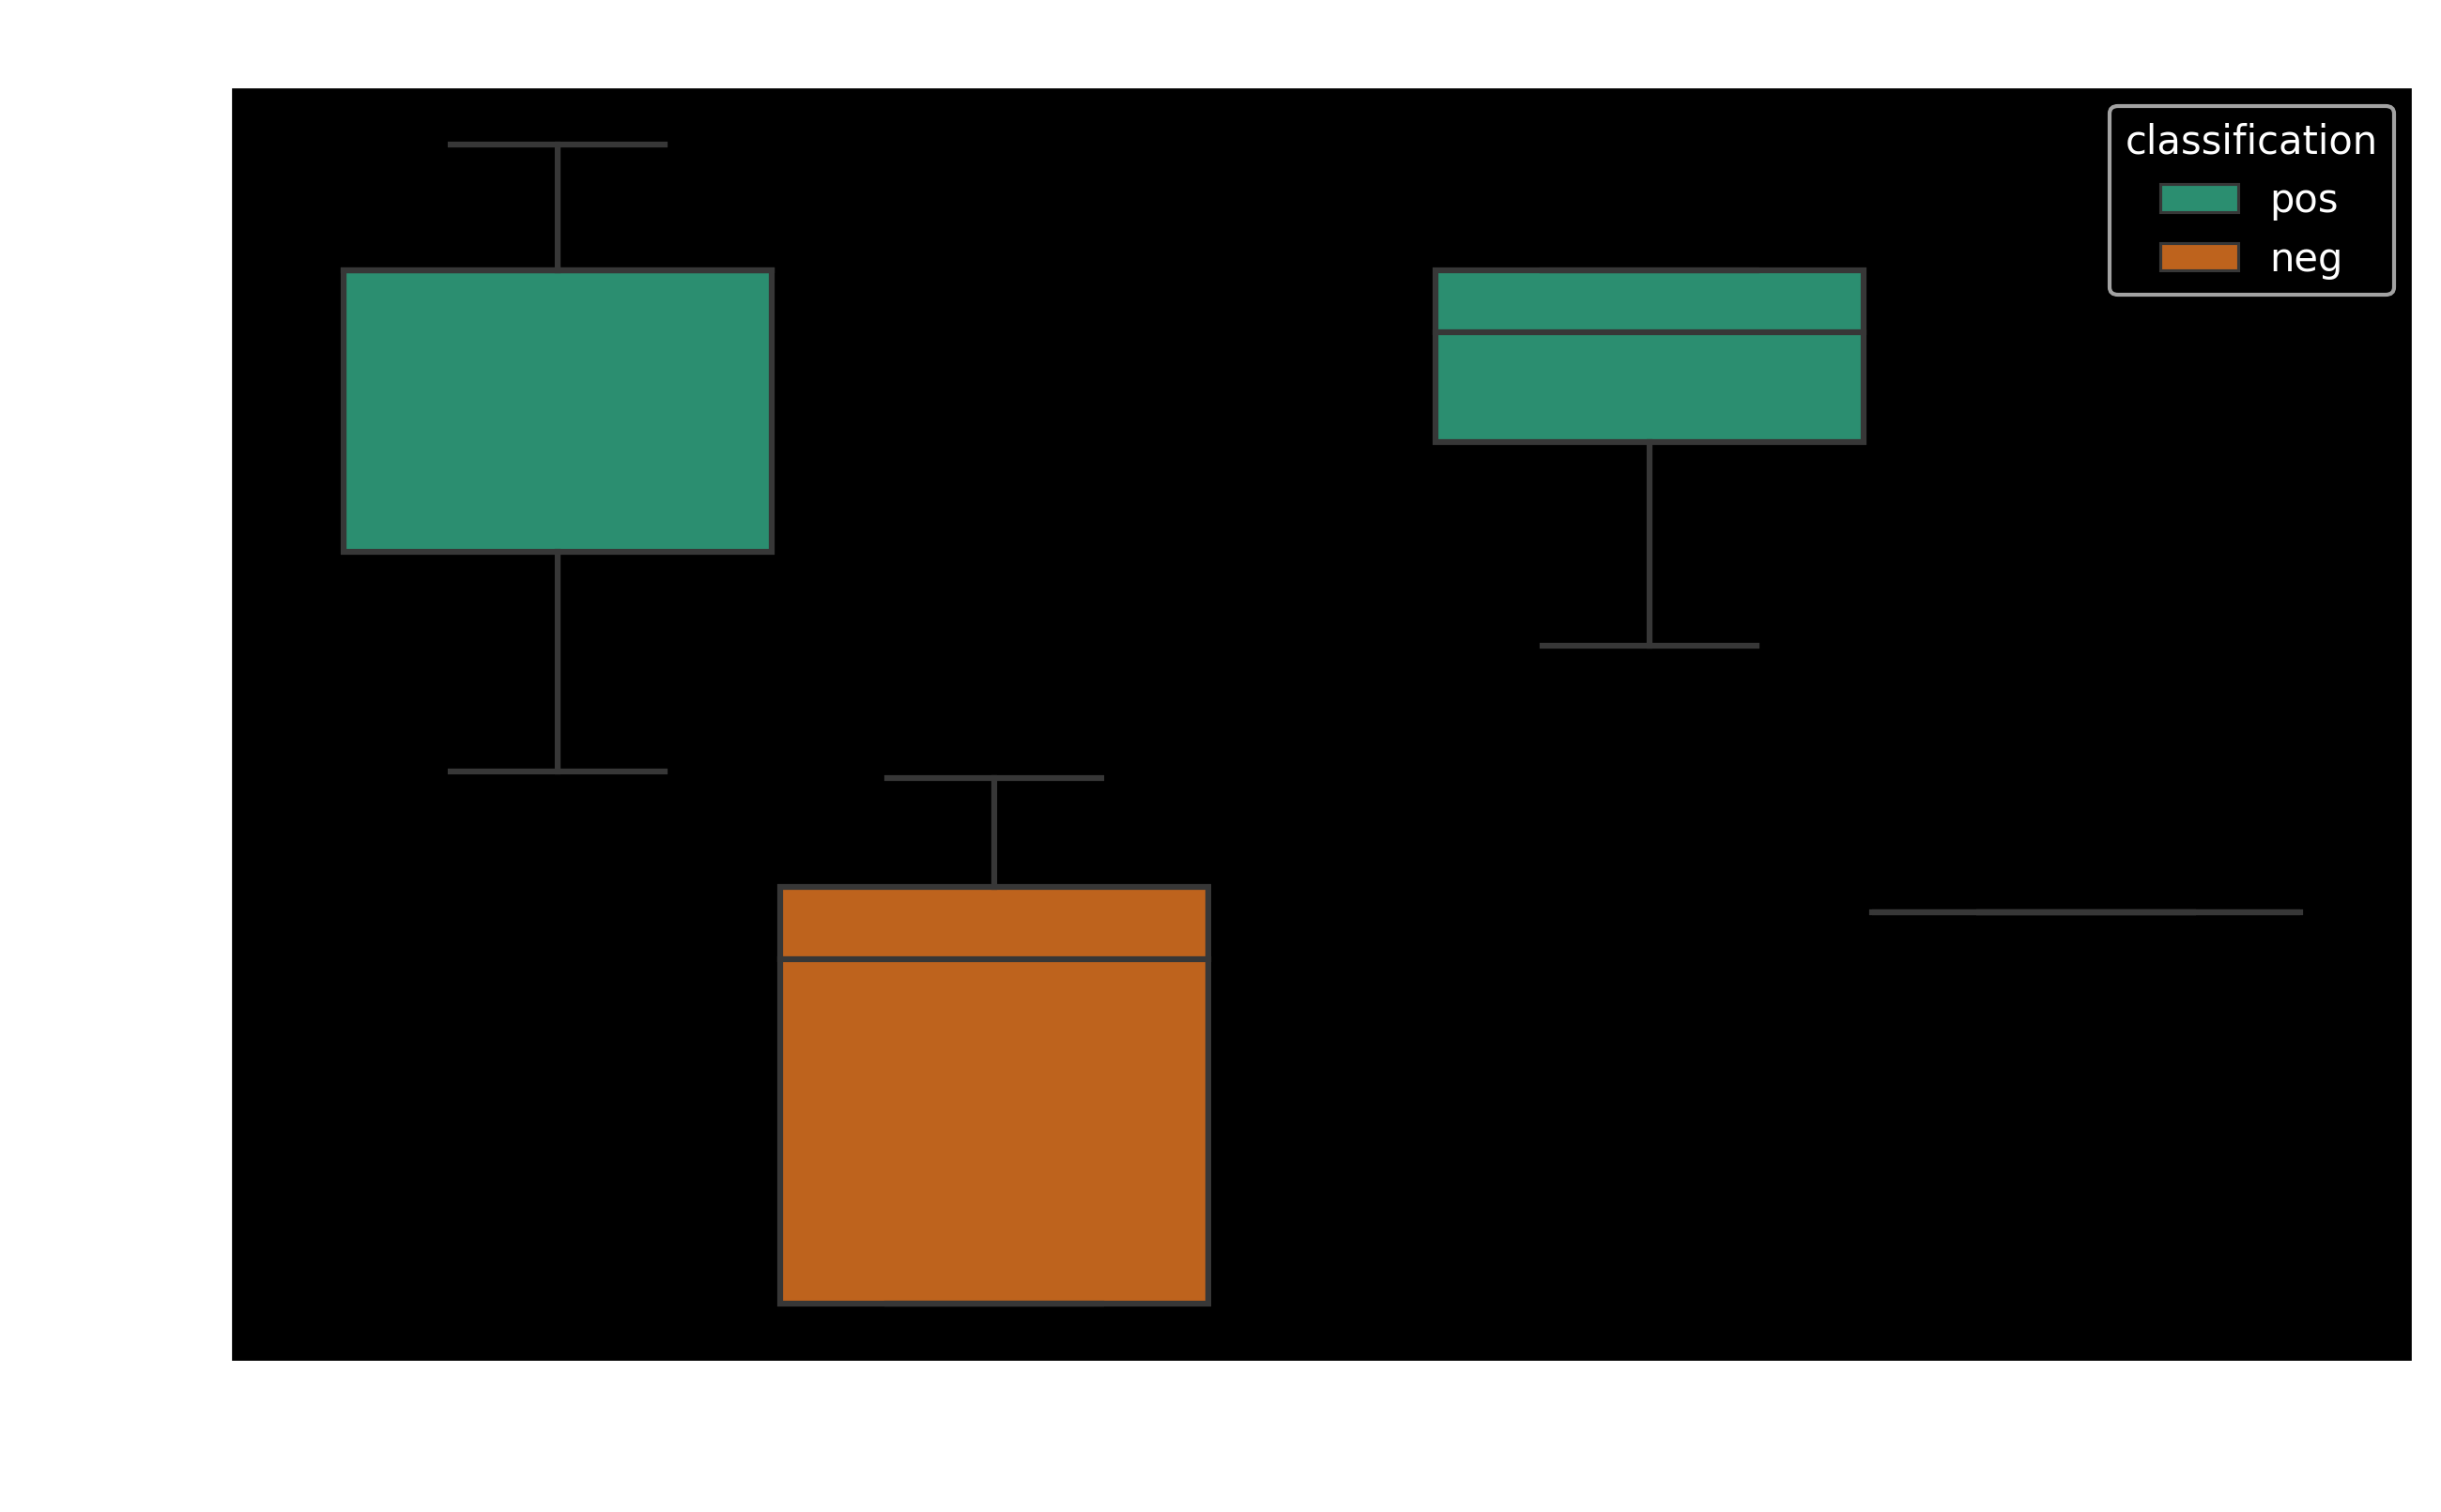

In [39]:
df_pn = df[df['classification'] != 'neu']

plt.figure(figsize=(10, 6), dpi=300)
sns.boxplot(x='verified', y='polarity', hue='classification', 
            data=df_pn, palette='Dark2').set_title('Positive & Negative Sentiment of Verified Twitter Users');